In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

[*********************100%***********************]  1 of 1 completed


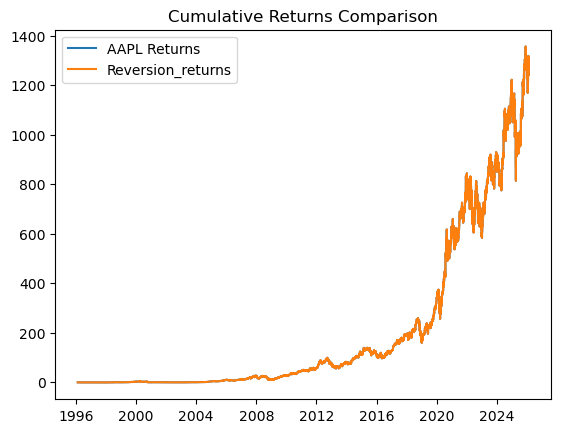

Price,Close,High,Low,Open,Volume,clv,signal,strategy,Asset_returns,strategy_returns
Date,,,,,,,,,,
1996-02-13,0.210677,0.216296,0.208805,0.209741,228502400,0.612821,1.0,NaN,NaN,NaN
1996-02-14,0.206932,0.211614,0.205528,0.211614,163184000,0.612821,1.0,1.0,-0.017777,-0.017777
1996-02-15,0.209741,0.210677,0.205060,0.206932,122080000,0.612821,1.0,1.0,-0.004444,-0.004444
1996-02-16,0.205996,0.212550,0.205996,0.210677,156441600,0.612821,1.0,1.0,-0.022221,-0.022221
1996-02-20,0.217232,0.220977,0.209741,0.209741,376913600,0.612821,1.0,1.0,0.031113,0.031113
...,...,...,...,...,...,...,...,...,...,...
2026-02-06,277.859985,280.647386,276.671095,276.860920,50453400,0.612821,1.0,1.0,1317.889082,1317.889082
2026-02-09,274.619995,278.200012,271.700012,277.910004,44623400,0.612821,1.0,1.0,1302.510157,1302.510157
2026-02-10,273.679993,275.369995,272.940002,274.890015,34376900,0.612821,1.0,1.0,1298.048345,1298.048345


In [27]:
ticker = "AAPL"
LOOKBACK = -10000

def get_data():
    df = yf.download(ticker, period = '30y', auto_adjust=True, interval='1d')
    df.sort_index(inplace=True)
    df.columns = df.columns.get_level_values(0)

    return df.iloc[LOOKBACK:,:]
    
def strategy(df):
    df['clv'] = (df['High'] - df['Close']).std() / (df['High'] - df['Low']  + 0.00001).std()
    # 1. Create purely Buy (1) and Sell (-1) signals, use NaN for "do nothing"
    conditions = [
        (df['clv'] > 0.5), # Condition 1: Short
        (df['clv'] < 0.5)  # Condition 2: Long
    ]
    choices = [1, -1]
    
    # Use np.select to assign 1 or -1, but default to NaN (np.nan) instead of 0
    df['signal'] = np.select(conditions, choices, default=np.nan)

    # 2. Forward Fill (The Memory)
    # This says: "If today is NaN, copy yesterday's position."
    df['strategy'] = df['signal'].ffill()

    # 3. Handle the start (replace initial NaNs with 0)
    df['strategy'] = df['strategy'].fillna(0)

    # 4. Shift to trade "tomorrow"
    df['strategy'] = df['strategy'].shift(1)

    return df

def test_strategy(df):
    df['Asset_returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['strategy_returns'] = (1 + df['Close'].pct_change() * df['strategy']).cumprod() - 1

    plt.figure()
    plt.plot(df['Asset_returns'], label=f'{ticker} Returns')
    plt.plot(df['strategy_returns'], label='Reversion_returns')
    plt.legend()
    plt.title('Cumulative Returns Comparison')
    plt.show()

    return df

def main():
    df = get_data()
    df = strategy(df)
    df = test_strategy(df)
    return df

main()